In [1]:
import numpy as np
import random
import simpy
import matplotlib.pyplot as plt
import SupplyNetPy.Components as scm

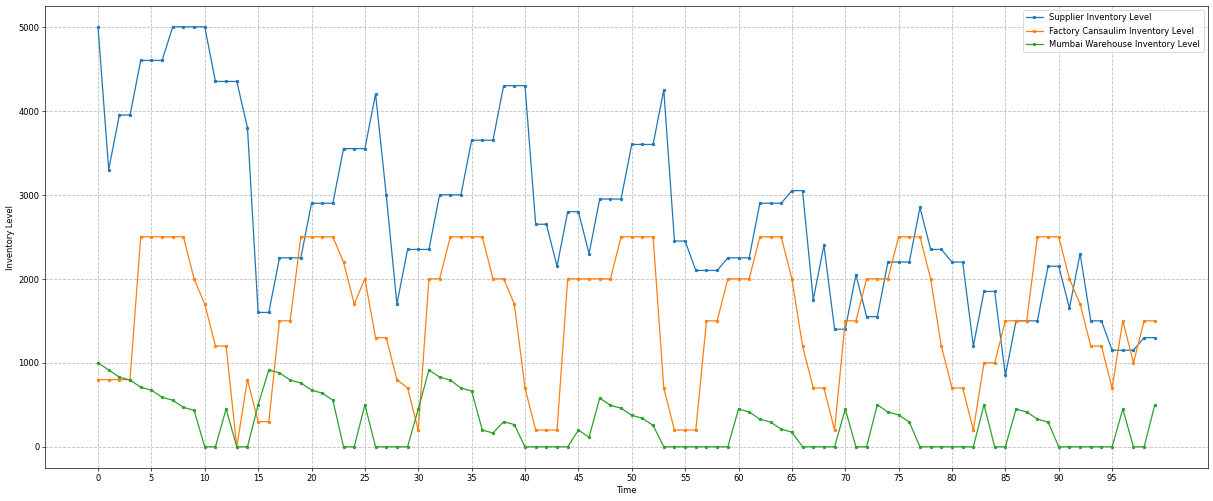

In [2]:
def print_dict(info: dict):
    for key, value in info.items():
        if type(value)==list:
            print(f"\t{key}: {len(value)} (list)")
        else:
            print(f"\t{key}: {value}")

simtime = 100
env = simpy.Environment()
raw_mat = scm.RawMaterial(ID="RM1", name="raw materials mouse", extraction_quantity=650,
                          extraction_time=3, mining_cost=0.01, cost=0.1)
#supplier = scm.Supplier(env=env, ID='S1', name='Supplier', node_type="infinite_supplier", raw_material=raw_mat)
supplier = scm.Supplier(env=env, ID='S1', name='Supplier', node_type="supplier", raw_material=raw_mat, capacity=5000, 
                        initial_level=5000, inventory_holding_cost=0.1)
mouse = scm.Product(ID="MW11", name="Toad M11", manufacturing_cost=10, manufacturing_time=1, sell_price=300, buy_price=150,
                             raw_materials=[(raw_mat,1)], batch_size=2500)
factory = scm.Manufacturer(env=env, ID='F1', name='Factory Cansaulim', capacity=2500, initial_level=800, shelf_life=10,
                           inventory_holding_cost=0.1, replenishment_policy=scm.SSReplenishment, policy_param={'s':1500, 'S':2500}, 
                           product=mouse, product_sell_price=300, inventory_type="perishable")
distributor = scm.InventoryNode(env=env, ID='D1', name='Mumbai Warehouse', node_type="warehouse", shelf_life=10,
                                capacity=1000, initial_level=1000, inventory_holding_cost=0.22,
                                replenishment_policy = scm.RQReplenishment, policy_param={'R':500, 'Q':500}, 
                                product_buy_price=300, product_sell_price=320, inventory_type="perishable")
link = scm.Link(env=env, ID='L1', source=supplier, sink=factory, cost=10, lead_time=lambda: 1)
link = scm.Link(env=env, ID='L1', source=factory, sink=distributor, cost=10, lead_time=lambda: 1)
demand1 = scm.Demand(env=env, ID='demand_D1', name='Demand Pune', order_arrival_model=lambda: 2, order_quantity_model=lambda:50, 
                     delivery_cost=lambda:10, lead_time=lambda:0.9, demand_node=distributor)
demand2 = scm.Demand(env=env, ID='demand_D2', name='Demand Kalyan', order_arrival_model=lambda: 1, order_quantity_model=lambda:35, 
                     delivery_cost=lambda:10, lead_time=lambda:0.9, demand_node=distributor)

scm.global_logger.disable_logging()
env.run(until=simtime)
from matplotlib.pyplot import figure
figure(figsize=(25, 10), dpi=60)
for node in [supplier, factory, distributor]:
    inv_levels = np.array(node.inventory.instantaneous_levels)
    plt.plot(inv_levels[:,0], inv_levels[:,1], label=f'{node.name} Inventory Level',marker='.')
plt.xlabel('Time')
plt.ylabel('Inventory Level')
xticks = np.arange(0, simtime, 5)
plt.xticks(xticks)
plt.grid(which='both', linestyle='--', linewidth=1, alpha=0.8)
plt.legend()
plt.show()

In [3]:

for node in [factory, distributor]: #   demand1, demand2
    print(f"Node: {node.name}")
    for key,value in node.stats.get_statistics().items():
        print(f"  {key}:{value}")

Node: Factory Cansaulim
  demand_placed:[24, 24900]
  fulfillment_received:[24, 24900]
  demand_received:[31, 15500]
  demand_fulfilled:[31, 15500]
  orders_shortage:[2, 600]
  backorder:[2, 1000]
  inventory_level:1500
  inventory_waste:8200
  inventory_carry_cost:16500.0
  inventory_spend_cost:2490.0
  transportation_cost:240
  node_cost:263230.0
  revenue:4650000
  profit:4386770.0
  total_products_manufactured:24400
  total_manufacturing_cost:244000
Node: Mumbai Warehouse
  demand_placed:[31, 15500]
  fulfillment_received:[31, 15500]
  demand_received:[97, 4010]
  demand_fulfilled:[97, 4010]
  orders_shortage:[53, 1990]
  backorder:[0, 0]
  inventory_level:465
  inventory_waste:11725
  inventory_carry_cost:9184.669999999998
  inventory_spend_cost:4650000
  transportation_cost:310
  node_cost:4659494.67
  revenue:1283200
  profit:-3376294.67
